In [1]:
import os 
import re

import pyedflib
import numpy as np 
import matplotlib.pyplot as plt

import skfda
import skfda.representation.basis as basis
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from skfda.representation.interpolation import SplineInterpolation

from scipy import stats 

#NOTE: dataset needs to be downloaded and unziped  

#filter edf files
eeg_signalfiles_names = list(filter(lambda s : s.endswith(".edf") , 
                            [os.path.abspath(os.path.join("../data/eeg-during-mental-arithmetic-tasks-1.0.0", f)) for 
                            f in os.listdir("../data/eeg-during-mental-arithmetic-tasks-1.0.0")]
                        ))

#dicts with subject_id - eeg_signal_filepath
before_arith_task = {}
after_arith_task = {}

# process each file
for edf_file_name in eeg_signalfiles_names :
    file_name = os.path.basename(edf_file_name)
    
    # extract subject identifier and suffix
    if "_1.edf" in file_name:
        subject_id = int(re.findall(r"\d\d", file_name)[0])
        before_arith_task[subject_id] = edf_file_name
    
    elif "_2.edf" in file_name:
        subject_id = int(re.findall(r"\d\d", file_name)[0])
        after_arith_task[subject_id] = edf_file_name

In [2]:
print("len of dict bat: ",len(before_arith_task.keys()))
print("len of dict aat: ",len(after_arith_task.keys()))

len of dict bat:  36
len of dict aat:  36


In [3]:
label_index_dict = {"Fp1":0,"Fp2":1,"F3":2,"F4":3,"F7":4,"F8":5,"T3":6,"T4":7,"C3":8,
                    "C4":9,"T5":10,"T6":11,"P3":12,"P4":13,"O1":14,"O2":15,"Fz":16, "Cz":17,"Pz":18}

In [4]:
f = pyedflib.EdfReader(after_arith_task[10])
#print edf file metadata
print(f.file_info_long())
eeg_signal = f.readSignal(label_index_dict.get("P4", None))

f.close()
print()
print("eeg signal number 0: ", eeg_signal)

file name: /home/enki/Documents/THESIS/FDA-EEG/data/eeg-during-mental-arithmetic-tasks-1.0.0/Subject10_2.edf
signals in file: 21
label: EEG Fp1 fs: 500.0 nsamples 31000
label: EEG Fp2 fs: 500.0 nsamples 31000
label: EEG F3 fs: 500.0 nsamples 31000
label: EEG F4 fs: 500.0 nsamples 31000
label: EEG F7 fs: 500.0 nsamples 31000
label: EEG F8 fs: 500.0 nsamples 31000
label: EEG T3 fs: 500.0 nsamples 31000
label: EEG T4 fs: 500.0 nsamples 31000
label: EEG C3 fs: 500.0 nsamples 31000
label: EEG C4 fs: 500.0 nsamples 31000
label: EEG T5 fs: 500.0 nsamples 31000
label: EEG T6 fs: 500.0 nsamples 31000
label: EEG P3 fs: 500.0 nsamples 31000
label: EEG P4 fs: 500.0 nsamples 31000
label: EEG O1 fs: 500.0 nsamples 31000
label: EEG O2 fs: 500.0 nsamples 31000
label: EEG Fz fs: 500.0 nsamples 31000
label: EEG Cz fs: 500.0 nsamples 31000
label: EEG Pz fs: 500.0 nsamples 31000
label: EEG A2-A1 fs: 500.0 nsamples 31000
label: ECG ECG fs: 500.0 nsamples 31000
None

eeg signal number 0:  [2.44373293e+00 3.

In [5]:
def eeg_data_matrix(subject_idx, subject_edfsignal_dict, labels):
    if subject_edfsignal_dict.get(subject_idx,-1) == -1:
        raise KeyError
    #build data matrix
    with pyedflib.EdfReader(subject_edfsignal_dict[subject_idx]) as f:
        eeg_signals_arr = []
        for label in labels:
            idx = label_index_dict.get(label,-1)
            if idx == -1:
               raise KeyError
            eeg_signal = f.readSignal(idx)
            eeg_signals_arr.append(eeg_signal)
        f.close()
        return np.matrix(eeg_signals_arr)

In [6]:
all_labels = list(label_index_dict.keys())
data = eeg_data_matrix(10,after_arith_task,all_labels)
print("data : ", data)

data :  [[ 4.31974845e-01  4.19345198e-01  2.16007886e-01 ... -1.22203845e-03
  -1.22203845e-03 -1.22203845e-03]
 [-4.33827385e+00 -5.65121156e+00 -7.42648991e+00 ...  1.14302800e-03
   1.14302800e-03  1.14302800e-03]
 [-2.15884351e+00 -2.78427478e+00 -3.74781047e+00 ... -1.76772412e-04
  -1.76772412e-04 -1.76772412e-04]
 ...
 [-3.34587261e+00 -4.35223917e+00 -5.82132920e+00 ... -8.15021286e-04
  -8.15021286e-04 -8.15021286e-04]
 [-8.33614751e-01 -2.08992257e+00 -3.79740630e+00 ...  7.77518883e-04
   7.77518883e-04  7.77518883e-04]
 [ 3.95831173e-01  6.14699885e-01  9.54675950e-01 ...  4.08368048e-04
   4.08368048e-04  4.08368048e-04]]


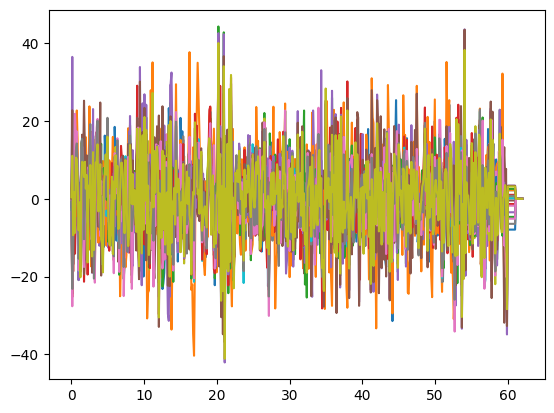

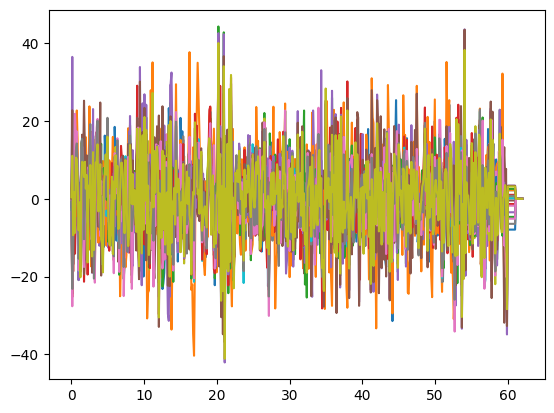

In [7]:
#raw eeg-signals transformed into functional data using 
#B-splines basis functions

fd = skfda.FDataGrid(
            data_matrix=data,
            grid_points=np.linspace(0,31000,31000)/500
        )
n_basis = 19

fd.plot()

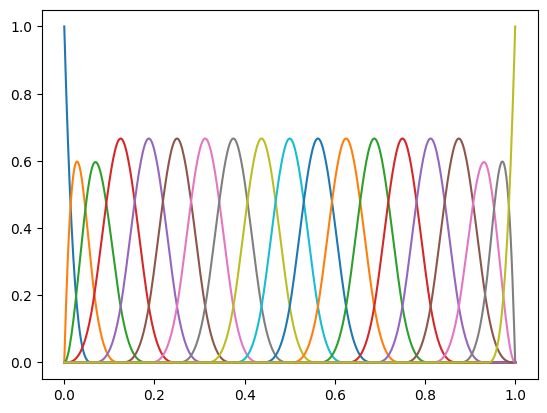

In [8]:
#plot b-spline basis
bspline_basis = skfda.representation.basis.BSplineBasis(n_basis=n_basis)
bspline_basis.plot()
plt.show()

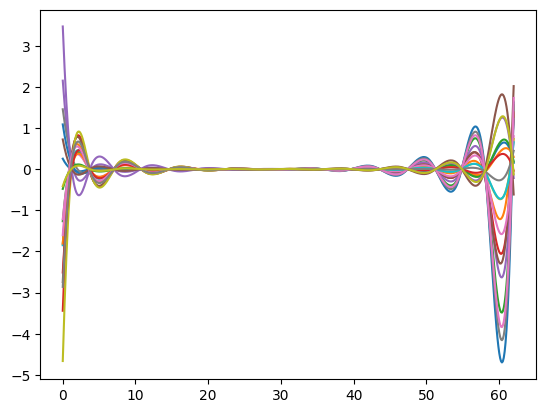

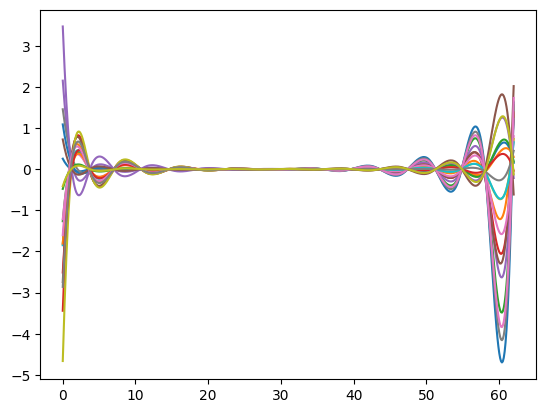

In [9]:
#plot of the eeg signals converted to functional data
fd_basis = fd.to_basis(basis.BSplineBasis(n_basis=n_basis))

fd_basis.plot()

singular vals:  [1.39245904e+02 2.85263597e+01 8.63144105e-01 1.20960205e-01
 1.80908349e-03 8.42848122e-04 3.72632195e-04 1.75096822e-04
 1.11623577e-04 1.82623168e-05 1.28553197e-05 5.43039444e-06
 1.90166723e-06 9.27759782e-07 2.09125833e-07 4.26827016e-08
 1.76517848e-08 1.21967089e-09 2.08688970e-33]


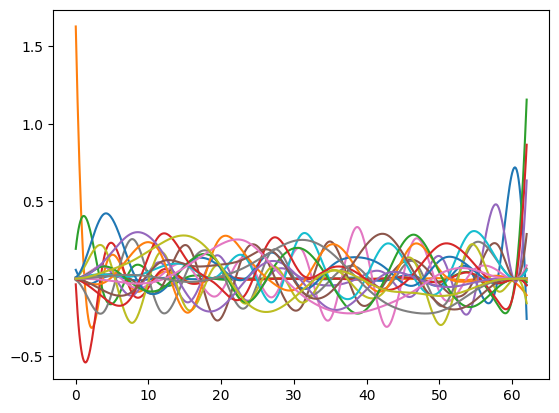

In [10]:
fpca = FPCA(n_basis)
fpca.fit(fd_basis)
fpca.components_.plot()

eigvals = np.square(fpca.singular_values_)
print("singular vals: ", eigvals)

In [ ]:
#compute here intercept and slope


In [ ]:
#plot truncated eigspectrum


In [ ]:
# r2 and KS test
